<a href="https://colab.research.google.com/github/SergeiVKalinin/MSE_Spring2025/blob/main/Module_4/22_PI_DeepONet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Physics Informed Deep Neural Operators
- Based on: https://towardsdatascience.com/operator-learning-via-physics-informed-deeponet-lets-implement-it-from-scratch-6659f3179887/
- Code at: https://github.com/ShuaiGuo16/PI-DeepONet/tree/main

### Objective

In this notebook, we develop a PI-DeepONet model that allows inputting external forcing term. Specifically, we investigate the following example equation:

\begin{equation}
\frac{ds(t)}{dt} = u(t), \; t \in [0, 1]
\end{equation}

with an initial condition $s(0)=0$.

### 0. Import libraries

In [14]:
!pip install keras==2.14.0 tensorflow==2.14.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0
  Attempting uninstall: google-auth-oauthlib
    Found existing ins

In [1]:
# Common packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from collections import defaultdict
from tqdm import tqdm
import time

import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(42)

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from scipy.integrate import solve_ivp

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

### 1. Data generation

We use a zero-mean Gaussian Process to generate the dataset for both training and testing.

In [2]:
def create_samples(length_scale, sample_num):
    """Create synthetic data for u(·)

    Args:
    ----
    length_scale: float, length scale for RNF kernel
    sample_num: number of u(·) profiles to generate

    Outputs:
    --------
    u_sample: generated u(·) profiles
    """

    # Define kernel with given length scale
    kernel = RBF(length_scale)

    # Create Gaussian process regressor
    gp = GaussianProcessRegressor(kernel=kernel)

    # collocation point locations
    X_sample = np.linspace(0, 1, 100).reshape(-1, 1)

    # create samples
    u_sample = np.zeros((sample_num, 100))
    for i in range(sample_num):
        n = np.random.randint(0, 10000)
        u_sample[i, :] = gp.sample_y(X_sample, random_state=n).flatten()  # sampling from the prior

    return u_sample

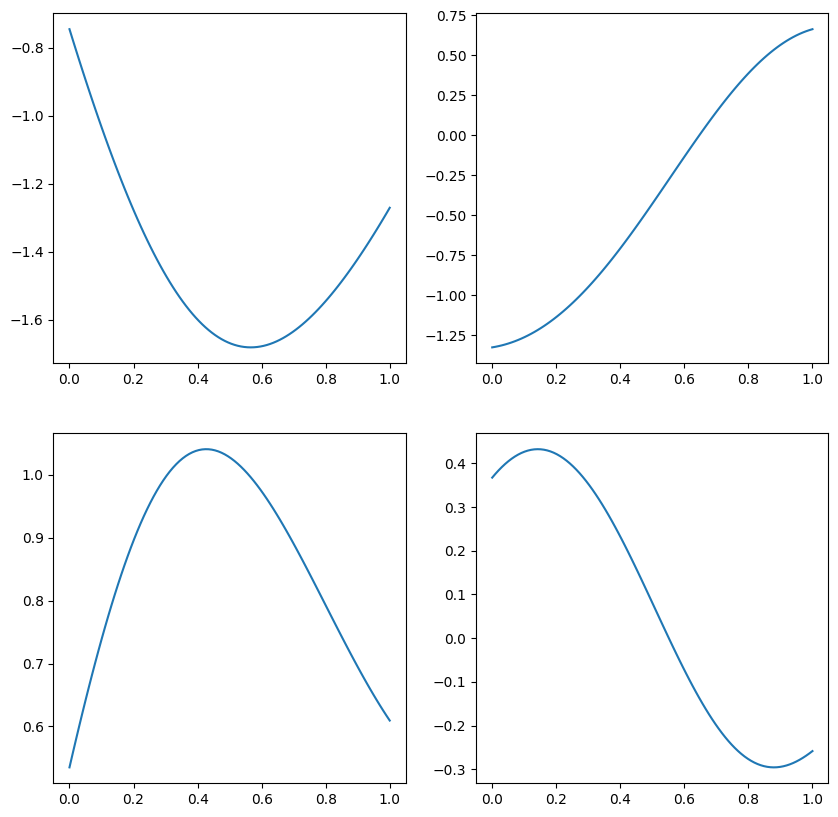

In [3]:
# Inspect generated data
length_scale = 0.6
N = 20
X_sample = np.linspace(0, 1, 100).reshape(-1, 1)
y_sample = create_samples(length_scale, N)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
index = np.random.choice(np.arange(0, N), size=4, replace=False)
for i in range(4):
    ax = axs[i // 2, i % 2]
    ax.plot(X_sample, y_sample[index[i]])

### 2. Organize dataset for PI-DeepONet

In [4]:
def generate_dataset(N, length_scale, ODE_solve=False):
    """Generate dataset for Physics-informed DeepONet training.

    Args:
    ----
    N: int, number of u(·) profiles
    length_scale: float, length scale for RNF kernel
    ODE_solve: boolean, indicate whether to compute the corresponding s(·)

    Outputs:
    --------
    X: the dataset for t, u(·) profiles, and u(t)
    y: the dataset for the corresponding ODE solution s(·)
    """

    # Create random fields
    random_field = create_samples(length_scale, N)

    # Compile dataset
    X = np.zeros((N*100, 100+2))
    y = np.zeros((N*100, 1))

    for i in tqdm(range(N)):
        u = np.tile(random_field[i, :], (100, 1))
        t = np.linspace(0, 1, 100).reshape(-1, 1)

        # u(·) evaluated at t
        u_t = np.diag(u).reshape(-1, 1)

        # Update overall matrix
        X[i*100:(i+1)*100, :] = np.concatenate((t, u, u_t), axis=1)

        # Solve ODE
        if ODE_solve:
            sol = solve_ivp(lambda var_t, var_s: np.interp(var_t, t.flatten(), random_field[i, :]),
                            t_span=[0, 1], y0=[0], t_eval=t.flatten(), method='RK45')
            y[i*100:(i+1)*100, :] = sol.y[0].reshape(-1, 1)

    return X, y

In [5]:
# Create training dataset
N_train = 2000
length_scale_train = 0.4
X_train, y_train = generate_dataset(N_train, length_scale_train)

# Create validation dataset
N_val = 100
length_scale_test = 0.4
X_val, y_val = generate_dataset(N_val, length_scale_test)

# Create testing dataset
N_test = 100
length_scale_test = 0.4
X_test, y_test = generate_dataset(N_test, length_scale_test, ODE_solve=True)

100%|██████████| 100/100 [00:00<00:00, 335.10it/s]


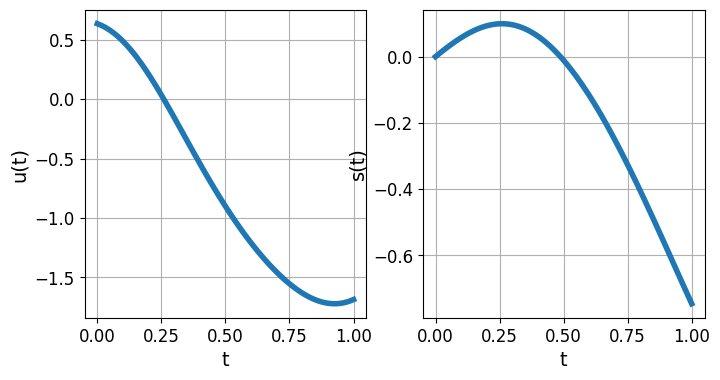

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
index = 25
ax[0].plot(np.linspace(0, 1, 100), X_test[index*100, 1:-1], lw=4)
ax[0].set_xlabel('t', fontsize=14)
ax[0].set_ylabel('u(t)', fontsize=14)
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].grid(True)

ax[1].plot(np.linspace(0, 1, 100), y_test[index*100:(index+1)*100], lw=4)
ax[1].set_xlabel('t', fontsize=14)
ax[1].set_ylabel('s(t)', fontsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].grid(True)

#### Separate initial condition and collocation points

In [7]:
# Determine batch size
ini_batch_size = int(2000/100)
col_batch_size = 2000

# Create dataset object (initial conditions)
X_train_ini = tf.convert_to_tensor(X_train[X_train[:, 0]==0], dtype=tf.float32)
ini_ds = tf.data.Dataset.from_tensor_slices((X_train_ini))
ini_ds = ini_ds.shuffle(5000).batch(ini_batch_size)


# Create dataset object (collocation points)
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
train_ds = tf.data.Dataset.from_tensor_slices((X_train))
train_ds = train_ds.shuffle(100000).batch(col_batch_size)

# Scaling
mean = {
    'forcing': np.mean(X_train[:, 1:-1], axis=0),
    'time': np.mean(X_train[:, :1], axis=0)
}

var = {
    'forcing': np.var(X_train[:, 1:-1], axis=0),
    'time': np.var(X_train[:, :1], axis=0)
}

### 3. Physics-informed DeepONet

#### Define a custom layer for adding a bias

In [8]:
class BiasLayer(tf.keras.layers.Layer):
    def build(self, input_shape):
        self.bias = self.add_weight(shape=(1,),
                                    initializer=tf.keras.initializers.Zeros(),
                                    trainable=True)
    def call(self, inputs):
        return inputs + self.bias

#### Define Physics-informed DeepONet

In [9]:
def create_model(mean, var, verbose=False):
    """Definition of a DeepONet with fully connected branch and trunk layers.

    Args:
    ----
    mean: dictionary, mean values of the inputs
    var: dictionary, variance values of the inputs
    verbose: boolean, indicate whether to show the model summary

    Outputs:
    --------
    model: the DeepONet model
    """

    # Branch net
    branch_input = tf.keras.Input(shape=(len(mean['forcing'])), name="forcing")
    branch = tf.keras.layers.Normalization(mean=mean['forcing'], variance=var['forcing'])(branch_input)
    for i in range(3):
        branch = tf.keras.layers.Dense(50, activation="tanh")(branch)

    # Trunk net
    trunk_input = tf.keras.Input(shape=(len(mean['time'])), name="time")
    trunk = tf.keras.layers.Normalization(mean=mean['time'], variance=var['time'])(trunk_input)
    for i in range(3):
        trunk = tf.keras.layers.Dense(50, activation="tanh")(trunk)

    # Compute the dot product between branch and trunk net
    dot_product = tf.reduce_sum(tf.multiply(branch, trunk), axis=1, keepdims=True)

    # Add the bias
    output = BiasLayer()(dot_product)

    # Create the model
    model = tf.keras.models.Model(inputs=[branch_input, trunk_input], outputs=output)

    if verbose:
        model.summary()

    return model

#### ODE loss

In [10]:
@tf.function
def ODE_residual_calculator(t, u, u_t, model):
    """ODE residual calculation.

    Args:
    ----
    t: temporal coordinate
    u: input function evaluated at discrete temporal coordinates
    u_t: input function evaluated at t
    model: DeepONet model

    Outputs:
    --------
    ODE_residual: residual of the governing ODE
    """

    with tf.GradientTape() as tape:
        tape.watch(t)
        s = model({"forcing": u, "time": t})

    # Calculate gradients
    ds_dt = tape.gradient(s, t)

    # ODE residual
    ODE_residual = ds_dt - u_t

    return ODE_residual

#### Gradient descent step

In [11]:
@tf.function
def train_step(X, X_init, IC_weight, ODE_weight, model):
    """Calculate gradients of the total loss with respect to network model parameters.

    Args:
    ----
    X: training dataset for evaluating ODE residuals
    X_init: training dataset for evaluating initial conditions
    IC_weight: weight for initial condition loss
    ODE_weight: weight for ODE loss
    model: DeepONet model

    Outputs:
    --------
    ODE_loss: calculated ODE loss
    IC_loss: calculated initial condition loss
    total_loss: weighted sum of ODE loss and initial condition loss
    gradients: gradients of the total loss with respect to network model parameters.
    """
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_weights)

        # Initial condition prediction
        y_pred_IC = model({"forcing": X_init[:, 1:-1], "time": X_init[:, :1]})

        # Equation residual
        ODE_residual = ODE_residual_calculator(t=X[:, :1], u=X[:, 1:-1], u_t=X[:, -1:], model=model)

        # Calculate loss
        IC_loss = tf.reduce_mean(keras.losses.mean_squared_error(0, y_pred_IC))
        ODE_loss = tf.reduce_mean(tf.square(ODE_residual))

        # Weight loss
        total_loss = IC_loss*IC_weight + ODE_loss*ODE_weight

    gradients = tape.gradient(total_loss, model.trainable_variables)

    return ODE_loss, IC_loss, total_loss, gradients

#### Define Loss Tracking class

In [12]:
class LossTracking:

    def __init__(self):
        self.mean_total_loss = keras.metrics.Mean()
        self.mean_IC_loss = keras.metrics.Mean()
        self.mean_ODE_loss = keras.metrics.Mean()
        self.loss_history = defaultdict(list)

    def update(self, total_loss, IC_loss, ODE_loss):
        self.mean_total_loss(total_loss)
        self.mean_IC_loss(IC_loss)
        self.mean_ODE_loss(ODE_loss)

    def reset(self):
        self.mean_total_loss.reset_states()
        self.mean_IC_loss.reset_states()
        self.mean_ODE_loss.reset_states()

    def print(self):
        print(f"IC={self.mean_IC_loss.result().numpy():.4e}, \
              ODE={self.mean_ODE_loss.result().numpy():.4e}, \
              total_loss={self.mean_total_loss.result().numpy():.4e}")

    def history(self):
        self.loss_history['total_loss'].append(self.mean_total_loss.result().numpy())
        self.loss_history['IC_loss'].append(self.mean_IC_loss.result().numpy())
        self.loss_history['ODE_loss'].append(self.mean_ODE_loss.result().numpy())

#### Training

In [14]:
# Set up training configurations
n_epochs = 300
IC_weight= tf.constant(1.0, dtype=tf.float32)
ODE_weight= tf.constant(1.0, dtype=tf.float32)
loss_tracker = LossTracking()
val_loss_hist = []

# One test sample prediction
pred_profiles = []

# Set up optimizer
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

with tf.device("CPU:0"):

    # Instantiate the PINN model
    PI_DeepONet = create_model(mean, var)
    PI_DeepONet.compile(optimizer=optimizer)

    # Configure callbacks
    _callbacks = [keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=30),
                 tf.keras.callbacks.ModelCheckpoint('NN_model.h5', monitor='val_loss', save_best_only=True)]
    callbacks = tf.keras.callbacks.CallbackList(
                    _callbacks, add_history=False, model=PI_DeepONet)

    # Start training process
    for epoch in range(1, n_epochs + 1):
        print(f"Epoch {epoch}:")

        for X_init, X in zip(ini_ds, train_ds):

            # Calculate gradients
            ODE_loss, IC_loss, total_loss, gradients = train_step(X, X_init,
                                                                IC_weight, ODE_weight,
                                                                PI_DeepONet)
            # Gradient descent
            PI_DeepONet.optimizer.apply_gradients(zip(gradients, PI_DeepONet.trainable_variables))


            # Loss tracking
            loss_tracker.update(total_loss, IC_loss, ODE_loss)

        # Loss summary
        loss_tracker.history()
        loss_tracker.print()
        loss_tracker.reset()

        ####### Validation
        val_res = ODE_residual_calculator(X_val[:, :1], X_val[:, 1:-1], X_val[:, -1:], PI_DeepONet)
        val_ODE = tf.cast(tf.reduce_mean(tf.square(val_res)), tf.float32)

        X_val_ini = X_val[X_val[:, 0]==0]
        pred_ini_valid = PI_DeepONet.predict({"forcing": X_val_ini[:, 1:-1], "time": X_val_ini[:, :1]}, batch_size=12800)
        val_IC = tf.reduce_mean(keras.losses.mean_squared_error(0, pred_ini_valid))
        print(f"val_IC: {val_IC.numpy():.4e}, val_ODE: {val_ODE.numpy():.4e}, lr: {PI_DeepONet.optimizer.lr.numpy():.2e}")


        # Callback at the end of epoch
        callbacks.on_epoch_end(epoch, logs={'val_loss': val_IC+val_ODE})
        val_loss_hist.append(val_IC+val_ODE)

        # Test dataset
        pred_test = PI_DeepONet.predict({"forcing": X_test[:, 1:-1], "time": X_test[:, :1]}, batch_size=12800)
        print(f"RMSE: {mean_squared_error(y_test.flatten(), pred_test.flatten())}")

        # Predict on one specific train samples
        sample_id = 25
        pred_profiles.append(PI_DeepONet.predict({"forcing": X_test[sample_id*100:(sample_id+1)*100, 1:-1],
                                            "time": X_test[sample_id*100:(sample_id+1)*100, :1]}, batch_size=12800))

        # Re-shuffle dataset
        ini_ds = tf.data.Dataset.from_tensor_slices((X_train_ini))
        ini_ds = ini_ds.shuffle(5000).batch(ini_batch_size)

        train_ds = tf.data.Dataset.from_tensor_slices((X_train))
        train_ds = train_ds.shuffle(100000).batch(col_batch_size)

Epoch 1:
IC=3.6956e-02,               ODE=2.1664e-01,               total_loss=2.5360e-01
1/1 [==============================] - 0s 105ms/step
val_IC: 5.0145e-03, val_ODE: 3.7505e-02, lr: 1.00e-03
1/1 [==============================] - 0s 40ms/step
RMSE: 0.01225166014148542
1/1 [==============================] - 0s 23ms/step
Epoch 2:
IC=3.1043e-03,               ODE=3.1325e-02,               total_loss=3.4429e-02
1/1 [==============================] - 0s 23ms/step
val_IC: 1.3560e-03, val_ODE: 2.1229e-02, lr: 1.00e-03
1/1 [==============================] - 0s 40ms/step
RMSE: 0.0034444862379436236
1/1 [==============================] - 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 3:
IC=8.8754e-04,               ODE=1.9089e-02,               total_loss=1.9977e-02
1/1 [==============================] - 0s 36ms/step
val_IC: 4.0313e-04, val_ODE: 1.4453e-02, lr: 1.00e-03
1/1 [==============================] - 0s 51ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.0015053433459384668
1/1 [==============================] - 0s 26ms/step
Epoch 4:
IC=4.5889e-04,               ODE=1.4106e-02,               total_loss=1.4565e-02
1/1 [==============================] - 0s 24ms/step
val_IC: 2.6490e-04, val_ODE: 1.1986e-02, lr: 1.00e-03
1/1 [==============================] - 0s 39ms/step
RMSE: 0.0010509045858407501
1/1 [==============================] - 0s 22ms/step
Epoch 5:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.5019e-04,               ODE=1.1858e-02,               total_loss=1.2208e-02
1/1 [==============================] - 0s 24ms/step
val_IC: 2.4707e-04, val_ODE: 9.9487e-03, lr: 1.00e-03
1/1 [==============================] - 0s 43ms/step
RMSE: 0.0008380089747399491
1/1 [==============================] - 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 6:
IC=2.8301e-04,               ODE=1.0017e-02,               total_loss=1.0300e-02
1/1 [==============================] - 0s 23ms/step
val_IC: 2.0042e-04, val_ODE: 8.5148e-03, lr: 1.00e-03
1/1 [==============================] - 0s 41ms/step
RMSE: 0.000603942674242719
1/1 [==============================] - 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 7:
IC=2.3382e-04,               ODE=8.3573e-03,               total_loss=8.5911e-03
1/1 [==============================] - 0s 23ms/step
val_IC: 1.7918e-04, val_ODE: 6.4981e-03, lr: 1.00e-03
1/1 [==============================] - 0s 41ms/step
RMSE: 0.00038231243218740554
1/1 [==============================] - 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 8:
IC=1.9445e-04,               ODE=6.3539e-03,               total_loss=6.5484e-03
1/1 [==============================] - 0s 23ms/step
val_IC: 1.6480e-04, val_ODE: 4.4709e-03, lr: 1.00e-03
1/1 [==============================] - 0s 39ms/step
RMSE: 0.0004430640151442399
1/1 [==============================] - 0s 22ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 9:
IC=1.6163e-04,               ODE=4.3617e-03,               total_loss=4.5233e-03
1/1 [==============================] - 0s 23ms/step
val_IC: 1.3826e-04, val_ODE: 3.2201e-03, lr: 1.00e-03
1/1 [==============================] - 0s 40ms/step
RMSE: 0.0002379101230405499
1/1 [==============================] - 0s 23ms/step
Epoch 10:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.2045e-04,               ODE=3.3111e-03,               total_loss=3.4315e-03
1/1 [==============================] - 0s 22ms/step
val_IC: 7.8825e-05, val_ODE: 2.7065e-03, lr: 1.00e-03
1/1 [==============================] - 0s 44ms/step
RMSE: 0.00026933198243421714
1/1 [==============================] - 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 11:
IC=1.2018e-04,               ODE=2.9814e-03,               total_loss=3.1016e-03
1/1 [==============================] - 0s 23ms/step
val_IC: 6.5514e-05, val_ODE: 2.5454e-03, lr: 1.00e-03
1/1 [==============================] - 0s 43ms/step
RMSE: 0.00028452816304786664
1/1 [==============================] - 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 12:
IC=1.2586e-04,               ODE=2.7804e-03,               total_loss=2.9063e-03
1/1 [==============================] - 0s 23ms/step
val_IC: 1.0402e-04, val_ODE: 2.4043e-03, lr: 1.00e-03
1/1 [==============================] - 0s 42ms/step
RMSE: 0.0002379877119701991
1/1 [==============================] - 0s 22ms/step
Epoch 13:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.8170e-05,               ODE=2.4880e-03,               total_loss=2.5862e-03
1/1 [==============================] - 0s 30ms/step
val_IC: 6.9116e-05, val_ODE: 2.2584e-03, lr: 1.00e-03
1/1 [==============================] - 0s 41ms/step
RMSE: 0.0001953941016985708
1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 26ms/step
Epoch 14:
IC=9.6726e-05,               ODE=2.3394e-03,               total_loss=2.4362e-03
1/1 [==============================] - 0s 22ms/step
val_IC: 1.3131e-04, val_ODE: 2.1414e-03, lr: 1.00e-03
1/1 [==============================] - 0s 42ms/step
RMSE: 0.00015216796080257596
1/1 [==============================] - 0s 22ms/step
Epoch 15:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.6399e-05,               ODE=2.3479e-03,               total_loss=2.4343e-03
1/1 [==============================] - 0s 22ms/step
val_IC: 4.6836e-05, val_ODE: 2.2048e-03, lr: 1.00e-03
1/1 [==============================] - 0s 40ms/step
RMSE: 0.0002854502248215614
1/1 [==============================] - 0s 22ms/step
Epoch 16:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.5564e-05,               ODE=2.2467e-03,               total_loss=2.3322e-03
1/1 [==============================] - 0s 24ms/step
val_IC: 1.1704e-04, val_ODE: 1.9863e-03, lr: 1.00e-03
1/1 [==============================] - 0s 40ms/step
RMSE: 0.0002699933900190945
1/1 [==============================] - 0s 23ms/step
Epoch 17:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.8365e-05,               ODE=2.0521e-03,               total_loss=2.1205e-03
1/1 [==============================] - 0s 24ms/step
val_IC: 3.4975e-05, val_ODE: 1.7288e-03, lr: 1.00e-03
1/1 [==============================] - 0s 42ms/step
RMSE: 0.00014130792894658894
1/1 [==============================] - 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 18:
IC=6.2044e-05,               ODE=2.1209e-03,               total_loss=2.1830e-03
1/1 [==============================] - 0s 25ms/step
val_IC: 3.4281e-05, val_ODE: 2.0217e-03, lr: 1.00e-03
1/1 [==============================] - 0s 39ms/step
RMSE: 0.0002491438902095545
1/1 [==============================] - 0s 27ms/step
Epoch 19:
IC=6.0042e-05,               ODE=1.9626e-03,               total_loss=2.0226e-03
1/1 [==============================] - 0s 24ms/step
val_IC: 2.8193e-05, val_ODE: 1.7959e-03, lr: 1.00e-03
1/1 [==============================] - 0s 36ms/step
RMSE: 0.0001555096746293316
1/1 [==============================] - 0s 22ms/step
Epoch 20:
IC=6.1582e-05,               ODE=1.9323e-03,               total_loss=1.9939e-03
1/1 [==============================] - 0s 23ms/step
val_IC: 5.1813e-05, val_ODE: 2.2359e-03, lr: 1.00e-03
1/1 [==============================] - 0s 37ms/step
RMSE: 0.00023801323261173453
1/1 [==============================] - 0s 22ms/step
Epoch 21:
IC

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 27ms/step
Epoch 22:
IC=4.8158e-05,               ODE=1.7674e-03,               total_loss=1.8156e-03
1/1 [==============================] - 0s 27ms/step
val_IC: 6.4443e-05, val_ODE: 1.7272e-03, lr: 1.00e-03
1/1 [==============================] - 0s 39ms/step
RMSE: 0.00017762741568687536
1/1 [==============================] - 0s 22ms/step
Epoch 23:
IC=4.2242e-05,               ODE=1.7058e-03,               total_loss=1.7480e-03
1/1 [==============================] - 0s 22ms/step
val_IC: 2.8021e-05, val_ODE: 1.7386e-03, lr: 1.00e-03
1/1 [==============================] - 0s 39ms/step
RMSE: 0.00018464656808112162
1/1 [==============================] - 0s 22ms/step
Epoch 24:
IC=6.2606e-05,               ODE=1.9756e-03,               total_loss=2.0382e-03
1/1 [==============================] - 0s 22ms/step
val_IC: 4.7086e-05, val_ODE: 1.7821e-03, lr: 1.00e-03
1/1 [==============================] - 0s 43ms/step
RMSE: 0.00022703042928662244
1/1 [=====

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.7543e-05,               ODE=1.6258e-03,               total_loss=1.6733e-03
1/1 [==============================] - 0s 22ms/step
val_IC: 4.3046e-05, val_ODE: 1.4543e-03, lr: 1.00e-03
1/1 [==============================] - 0s 40ms/step
RMSE: 0.00013932480691172127
1/1 [==============================] - 0s 27ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 27:
IC=4.2732e-05,               ODE=1.6817e-03,               total_loss=1.7245e-03
1/1 [==============================] - 0s 22ms/step
val_IC: 2.9159e-05, val_ODE: 1.5499e-03, lr: 1.00e-03
1/1 [==============================] - 0s 39ms/step
RMSE: 0.0001846007254190352
1/1 [==============================] - 0s 23ms/step
Epoch 28:
IC=7.6667e-05,               ODE=2.0794e-03,               total_loss=2.1561e-03
1/1 [==============================] - 0s 23ms/step
val_IC: 2.1400e-05, val_ODE: 1.7513e-03, lr: 1.00e-03
1/1 [==============================] - 0s 41ms/step
RMSE: 0.0002854818819412615
1/1 [==============================] - 0s 24ms/step
Epoch 29:
IC=3.3805e-05,               ODE=1.4736e-03,               total_loss=1.5074e-03
1/1 [==============================] - 0s 22ms/step
val_IC: 2.4402e-05, val_ODE: 1.4342e-03, lr: 1.00e-03
1/1 [==============================] - 0s 41ms/step
RMSE: 0.00017621292499461988
1/1 [==============================] - 0s 22ms/step
Epoch 30:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.1093e-05,               ODE=1.7182e-03,               total_loss=1.7693e-03
1/1 [==============================] - 0s 40ms/step
val_IC: 2.8071e-05, val_ODE: 1.6705e-03, lr: 1.00e-03
1/1 [==============================] - 0s 68ms/step
RMSE: 0.0002329770642760699
1/1 [==============================] - 0s 34ms/step
Epoch 31:
IC=5.2019e-05,               ODE=1.6940e-03,               total_loss=1.7460e-03
1/1 [==============================] - 0s 23ms/step
val_IC: 3.6052e-05, val_ODE: 1.2103e-03, lr: 1.00e-03
1/1 [==============================] - 0s 40ms/step
RMSE: 7.362895969200624e-05
1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 24ms/step
Epoch 32:
IC=3.8838e-05,               ODE=1.5103e-03,               total_loss=1.5492e-03
1/1 [==============================] - 0s 22ms/step
val_IC: 1.5289e-05, val_ODE: 1.4750e-03, lr: 1.00e-03
1/1 [==============================] - 0s 40ms/step
RMSE: 0.00014186864034354177
1/1 [==============================] - 0s 23ms/step
Epoch 33:
IC=4.9113e-05,               ODE=1.8757e-03,               total_loss=1.9249e-03
1/1 [==============================] - 0s 23ms/step
val_IC: 4.6397e-05, val_ODE: 1.4539e-03, lr: 1.00e-03
1/1 [==============================] - 0s 51ms/step
RMSE: 0.00011305090366372612
1/1 [==============================] - 0s 24ms/step
Epoch 34:
IC=5.8334e-05,               ODE=1.7020e-03,               total_loss=1.7603e-03
1/1 [==============================] - 0s 23ms/step
val_IC: 3.4160e-05, val_ODE: 1.1924e-03, lr: 1.00e-03
1/1 [==============================] - 0s 41ms/step
RMSE: 6.390310245460662e-05
1/1 [======

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.6576e-05,               ODE=1.3037e-03,               total_loss=1.3403e-03
1/1 [==============================] - 0s 22ms/step
val_IC: 5.4458e-05, val_ODE: 1.1891e-03, lr: 1.00e-03
1/1 [==============================] - 0s 38ms/step
RMSE: 7.774698486775778e-05
1/1 [==============================] - 0s 22ms/step
Epoch 36:
IC=1.3314e-04,               ODE=2.8297e-03,               total_loss=2.9629e-03
1/1 [==============================] - 0s 29ms/step
val_IC: 3.9771e-05, val_ODE: 1.4292e-03, lr: 1.00e-03
1/1 [==============================] - 0s 43ms/step
RMSE: 0.00019417465700918954
1/1 [==============================] - 0s 23ms/step
Epoch 37:
IC=3.2578e-05,               ODE=1.2157e-03,               total_loss=1.2483e-03
1/1 [==============================] - 0s 25ms/step
val_IC: 2.5194e-05, val_ODE: 1.2220e-03, lr: 1.00e-03
1/1 [==============================] - 0s 39ms/step
RMSE: 6.91960220489637e-05
1/1 [==============================] - 0s 22ms/step
Epoch 38:
IC=7.5282e-05

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 27ms/step
Epoch 40:
IC=4.5057e-05,               ODE=1.3066e-03,               total_loss=1.3517e-03
1/1 [==============================] - 0s 23ms/step
val_IC: 3.5379e-05, val_ODE: 1.2459e-03, lr: 1.00e-03
1/1 [==============================] - 0s 38ms/step
RMSE: 7.32545183431117e-05
1/1 [==============================] - 0s 31ms/step
Epoch 41:
IC=6.6692e-05,               ODE=1.7567e-03,               total_loss=1.8234e-03
1/1 [==============================] - 0s 23ms/step
val_IC: 3.1410e-05, val_ODE: 1.0425e-03, lr: 1.00e-03
1/1 [==============================] - 0s 39ms/step
RMSE: 6.336881437735674e-05
1/1 [==============================] - 0s 22ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 42:
IC=5.0131e-05,               ODE=1.2600e-03,               total_loss=1.3101e-03
1/1 [==============================] - 0s 23ms/step
val_IC: 3.1568e-05, val_ODE: 1.0510e-03, lr: 1.00e-03
1/1 [==============================] - 0s 39ms/step
RMSE: 0.00016152813767508832
1/1 [==============================] - 0s 23ms/step
Epoch 43:
IC=5.0008e-05,               ODE=1.4449e-03,               total_loss=1.4949e-03
1/1 [==============================] - 0s 23ms/step
val_IC: 3.8636e-05, val_ODE: 1.6117e-03, lr: 1.00e-03
1/1 [==============================] - 0s 46ms/step
RMSE: 0.00022151379354336237
1/1 [==============================] - 0s 26ms/step
Epoch 44:
IC=5.0705e-05,               ODE=1.5438e-03,               total_loss=1.5945e-03
1/1 [==============================] - 0s 22ms/step
val_IC: 9.7079e-06, val_ODE: 1.1232e-03, lr: 1.00e-03
1/1 [==============================] - 0s 39ms/step
RMSE: 0.00010476936530467648
1/1 [==============================] - 0s 23ms/step
Epoch 45:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 27ms/step
Epoch 46:
IC=5.2795e-05,               ODE=1.4159e-03,               total_loss=1.4687e-03
1/1 [==============================] - 0s 23ms/step
val_IC: 8.4757e-05, val_ODE: 1.3576e-03, lr: 1.00e-03
1/1 [==============================] - 0s 39ms/step
RMSE: 0.00013095828343435916
1/1 [==============================] - 0s 23ms/step
Epoch 47:
IC=3.4174e-05,               ODE=1.1052e-03,               total_loss=1.1393e-03
1/1 [==============================] - 0s 23ms/step
val_IC: 4.5636e-05, val_ODE: 9.6701e-04, lr: 1.00e-03
1/1 [==============================] - 0s 38ms/step
RMSE: 9.960357292733919e-05
1/1 [==============================] - 0s 23ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 48:
IC=5.2944e-05,               ODE=1.3277e-03,               total_loss=1.3807e-03
1/1 [==============================] - 0s 24ms/step
val_IC: 4.6291e-05, val_ODE: 9.0207e-04, lr: 1.00e-03
1/1 [==============================] - 0s 44ms/step
RMSE: 0.00015484952814900105


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 27ms/step
Epoch 49:
IC=5.1985e-05,               ODE=1.0659e-03,               total_loss=1.1179e-03
1/1 [==============================] - 0s 23ms/step
val_IC: 6.3556e-05, val_ODE: 1.1100e-03, lr: 1.00e-03
1/1 [==============================] - 0s 37ms/step
RMSE: 0.0002033729934101888
1/1 [==============================] - 0s 24ms/step
Epoch 50:
IC=5.2600e-05,               ODE=1.0044e-03,               total_loss=1.0570e-03
1/1 [==============================] - 0s 22ms/step
val_IC: 4.4575e-05, val_ODE: 6.4814e-04, lr: 1.00e-03
1/1 [==============================] - 0s 40ms/step
RMSE: 0.00011722040143082947
1/1 [==============================] - 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 51:
IC=6.9069e-05,               ODE=1.4869e-03,               total_loss=1.5560e-03
1/1 [==============================] - 0s 29ms/step
val_IC: 2.1807e-05, val_ODE: 6.0380e-04, lr: 1.00e-03
1/1 [==============================] - 0s 42ms/step
RMSE: 9.023343194972611e-05


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 30ms/step
Epoch 52:
IC=3.7207e-05,               ODE=7.2855e-04,               total_loss=7.6576e-04
1/1 [==============================] - 0s 24ms/step
val_IC: 1.8814e-05, val_ODE: 7.4204e-04, lr: 1.00e-03
1/1 [==============================] - 0s 38ms/step
RMSE: 0.00015945029838161474
1/1 [==============================] - 0s 22ms/step
Epoch 53:
IC=6.4542e-05,               ODE=9.6093e-04,               total_loss=1.0255e-03
1/1 [==============================] - 0s 25ms/step
val_IC: 1.6706e-05, val_ODE: 4.6572e-04, lr: 1.00e-03
1/1 [==============================] - 0s 41ms/step
RMSE: 7.711076352519812e-05


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 32ms/step
Epoch 54:
IC=3.5604e-05,               ODE=7.8835e-04,               total_loss=8.2395e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 8.9265e-05, val_ODE: 8.9751e-04, lr: 1.00e-03
1/1 [==============================] - 0s 41ms/step
RMSE: 0.0003584169440142214
1/1 [==============================] - 0s 23ms/step
Epoch 55:
IC=1.0381e-04,               ODE=1.3131e-03,               total_loss=1.4169e-03
1/1 [==============================] - 0s 23ms/step
val_IC: 1.9900e-05, val_ODE: 6.1413e-04, lr: 1.00e-03
1/1 [==============================] - 0s 38ms/step
RMSE: 8.630675009009732e-05
1/1 [==============================] - 0s 24ms/step
Epoch 56:
IC=2.8420e-05,               ODE=5.7896e-04,               total_loss=6.0738e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 1.2207e-05, val_ODE: 4.0267e-04, lr: 1.00e-03
1/1 [==============================] - 0s 45ms/step
RMSE: 0.00011883155509498238


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 36ms/step
Epoch 57:
IC=4.0675e-05,               ODE=7.8311e-04,               total_loss=8.2379e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 2.6219e-05, val_ODE: 4.0329e-04, lr: 1.00e-03
1/1 [==============================] - 0s 43ms/step
RMSE: 6.882790162149906e-05
1/1 [==============================] - 0s 24ms/step
Epoch 58:
IC=4.4087e-05,               ODE=5.9433e-04,               total_loss=6.3841e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 2.7759e-05, val_ODE: 6.1156e-04, lr: 1.00e-03
1/1 [==============================] - 0s 46ms/step
RMSE: 0.0001422031000153836
1/1 [==============================] - 0s 22ms/step
Epoch 59:
IC=3.8740e-05,               ODE=8.7752e-04,               total_loss=9.1626e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 1.9989e-05, val_ODE: 4.7623e-04, lr: 1.00e-03
1/1 [==============================] - 0s 36ms/step
RMSE: 0.00015761864423925674
1/1 [=======

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 27ms/step
Epoch 61:
IC=3.0989e-05,               ODE=4.5998e-04,               total_loss=4.9097e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 3.2593e-05, val_ODE: 8.3373e-04, lr: 1.00e-03
1/1 [==============================] - 0s 36ms/step
RMSE: 0.0003187609356721874
1/1 [==============================] - 0s 22ms/step
Epoch 62:
IC=7.6416e-05,               ODE=1.0283e-03,               total_loss=1.1047e-03
1/1 [==============================] - 0s 22ms/step
val_IC: 1.9304e-05, val_ODE: 2.6901e-04, lr: 1.00e-03
1/1 [==============================] - 0s 40ms/step
RMSE: 3.8292851234762323e-05
1/1 [==============================] - 0s 22ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 63:
IC=3.2543e-05,               ODE=7.8252e-04,               total_loss=8.1506e-04
1/1 [==============================] - 0s 25ms/step
val_IC: 1.5391e-05, val_ODE: 3.2213e-04, lr: 1.00e-03
1/1 [==============================] - 0s 44ms/step
RMSE: 6.368162493525337e-05
1/1 [==============================] - 0s 23ms/step
Epoch 64:
IC=3.3323e-05,               ODE=5.1053e-04,               total_loss=5.4386e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 1.1144e-05, val_ODE: 3.4502e-04, lr: 1.00e-03
1/1 [==============================] - 0s 39ms/step
RMSE: 6.419619053002914e-05
1/1 [==============================] - 0s 22ms/step
Epoch 65:
IC=7.2986e-05,               ODE=1.0222e-03,               total_loss=1.0952e-03
1/1 [==============================] - 0s 22ms/step
val_IC: 9.8900e-06, val_ODE: 3.3648e-04, lr: 1.00e-03
1/1 [==============================] - 0s 40ms/step
RMSE: 5.615118375066509e-05
1/1 [==============================] - 0s 22ms/step
Epoch 66:
IC=

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.9458e-05,               ODE=5.5634e-04,               total_loss=5.7579e-04
1/1 [==============================] - 0s 27ms/step
val_IC: 1.1894e-05, val_ODE: 2.8179e-04, lr: 1.00e-03
1/1 [==============================] - 0s 48ms/step
RMSE: 4.6535425127473204e-05
1/1 [==============================] - 0s 25ms/step
Epoch 70:
IC=2.0751e-05,               ODE=4.6916e-04,               total_loss=4.8991e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 1.4009e-05, val_ODE: 3.5165e-04, lr: 1.00e-03
1/1 [==============================] - 0s 38ms/step
RMSE: 5.799604980771642e-05
1/1 [==============================] - 0s 22ms/step
Epoch 71:
IC=1.0979e-04,               ODE=1.2962e-03,               total_loss=1.4060e-03
1/1 [==============================] - 0s 23ms/step
val_IC: 6.6219e-06, val_ODE: 2.5897e-04, lr: 1.00e-03
1/1 [==============================] - 0s 40ms/step
RMSE: 4.7031318179558165e-05
1/1 [==============================] - 0s 23ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 72:
IC=2.2309e-05,               ODE=4.8610e-04,               total_loss=5.0841e-04
1/1 [==============================] - 0s 24ms/step
val_IC: 1.6380e-05, val_ODE: 3.2353e-04, lr: 1.00e-03
1/1 [==============================] - 0s 39ms/step
RMSE: 3.536534966402367e-05
1/1 [==============================] - 0s 23ms/step
Epoch 73:
IC=2.1357e-05,               ODE=6.8463e-04,               total_loss=7.0598e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 1.7610e-05, val_ODE: 3.3210e-04, lr: 1.00e-03
1/1 [==============================] - 0s 41ms/step
RMSE: 4.2010625014174624e-05
1/1 [==============================] - 0s 24ms/step
Epoch 74:
IC=1.8514e-05,               ODE=5.0657e-04,               total_loss=5.2509e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 8.0684e-06, val_ODE: 2.2427e-04, lr: 1.00e-03
1/1 [==============================] - 0s 51ms/step
RMSE: 2.9831702895207336e-05


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 28ms/step
Epoch 75:
IC=1.8848e-03,               ODE=1.4218e-02,               total_loss=1.6102e-02
1/1 [==============================] - 0s 30ms/step
val_IC: 4.5606e-05, val_ODE: 1.3923e-03, lr: 1.00e-03
1/1 [==============================] - 0s 43ms/step
RMSE: 0.0001976698394428253
1/1 [==============================] - 0s 27ms/step
Epoch 76:
IC=2.4501e-05,               ODE=9.2632e-04,               total_loss=9.5082e-04
1/1 [==============================] - 0s 24ms/step
val_IC: 9.5030e-06, val_ODE: 6.2923e-04, lr: 1.00e-03
1/1 [==============================] - 0s 42ms/step
RMSE: 6.30769425946906e-05
1/1 [==============================] - 0s 23ms/step
Epoch 77:
IC=1.5927e-05,               ODE=5.4708e-04,               total_loss=5.6300e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 9.2289e-06, val_ODE: 3.9526e-04, lr: 1.00e-03
1/1 [==============================] - 0s 39ms/step
RMSE: 5.3019793619554366e-05
1/1 [========

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 71ms/step
RMSE: 4.625332705622376e-05
1/1 [==============================] - 0s 40ms/step
Epoch 81:
IC=5.0331e-05,               ODE=1.1380e-03,               total_loss=1.1884e-03
1/1 [==============================] - 0s 24ms/step
val_IC: 5.9941e-06, val_ODE: 2.0926e-04, lr: 1.00e-03
1/1 [==============================] - 0s 55ms/step
RMSE: 3.1935562040622564e-05


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 25ms/step
Epoch 82:
IC=7.1008e-06,               ODE=2.4061e-04,               total_loss=2.4771e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 3.7808e-06, val_ODE: 2.0577e-04, lr: 1.00e-03
1/1 [==============================] - 0s 46ms/step
RMSE: 2.8097179882086788e-05


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 28ms/step
Epoch 83:
IC=8.0202e-06,               ODE=4.0945e-04,               total_loss=4.1747e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 5.8809e-06, val_ODE: 1.8318e-04, lr: 1.00e-03
1/1 [==============================] - 0s 46ms/step
RMSE: 2.526687141169469e-05


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 34ms/step
Epoch 84:
IC=7.6221e-06,               ODE=2.5929e-04,               total_loss=2.6691e-04
1/1 [==============================] - 0s 24ms/step
val_IC: 7.6796e-06, val_ODE: 2.7972e-04, lr: 1.00e-03
1/1 [==============================] - 0s 40ms/step
RMSE: 5.613895849114037e-05
1/1 [==============================] - 0s 23ms/step
Epoch 85:
IC=1.4868e-05,               ODE=6.9813e-04,               total_loss=7.1300e-04
1/1 [==============================] - 0s 39ms/step
val_IC: 8.3374e-06, val_ODE: 2.1865e-04, lr: 1.00e-03
1/1 [==============================] - 0s 68ms/step
RMSE: 3.512565638524046e-05
1/1 [==============================] - 0s 39ms/step
Epoch 86:
IC=1.6753e-05,               ODE=6.2348e-04,               total_loss=6.4023e-04
1/1 [==============================] - 0s 24ms/step
val_IC: 5.0054e-06, val_ODE: 2.5892e-04, lr: 1.00e-03
1/1 [==============================] - 0s 41ms/step
RMSE: 4.558398844444293e-05
1/1 [========

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 94:
IC=4.8705e-06,               ODE=1.8360e-04,               total_loss=1.8847e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 4.3265e-06, val_ODE: 1.5975e-04, lr: 5.00e-04
1/1 [==============================] - 0s 37ms/step
RMSE: 2.4434061678923616e-05
1/1 [==============================] - 0s 23ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 95:
IC=4.9577e-06,               ODE=1.7608e-04,               total_loss=1.8104e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 3.1138e-06, val_ODE: 1.5010e-04, lr: 5.00e-04
1/1 [==============================] - 0s 44ms/step
RMSE: 2.0208183648047433e-05


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 26ms/step
Epoch 96:
IC=4.7396e-06,               ODE=1.6893e-04,               total_loss=1.7367e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 6.2312e-06, val_ODE: 1.5217e-04, lr: 5.00e-04
1/1 [==============================] - 0s 40ms/step
RMSE: 2.5233814220422158e-05
1/1 [==============================] - 0s 23ms/step
Epoch 97:
IC=4.4712e-06,               ODE=1.7202e-04,               total_loss=1.7649e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 7.5382e-06, val_ODE: 1.5132e-04, lr: 5.00e-04
1/1 [==============================] - 0s 39ms/step
RMSE: 2.202691272812517e-05
1/1 [==============================] - 0s 23ms/step
Epoch 98:
IC=4.3073e-06,               ODE=1.6512e-04,               total_loss=1.6943e-04
1/1 [==============================] - 0s 25ms/step
val_IC: 3.5767e-06, val_ODE: 1.5692e-04, lr: 5.00e-04
1/1 [==============================] - 0s 55ms/step
RMSE: 2.059788103223246e-05
1/1 [=======

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 103:
IC=5.3476e-06,               ODE=2.3732e-04,               total_loss=2.4266e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 2.8944e-06, val_ODE: 2.3519e-04, lr: 5.00e-04
1/1 [==============================] - 0s 39ms/step
RMSE: 3.947950725119429e-05
1/1 [==============================] - 0s 23ms/step
Epoch 104:
IC=6.4558e-06,               ODE=1.8502e-04,               total_loss=1.9148e-04
1/1 [==============================] - 0s 24ms/step
val_IC: 1.1821e-05, val_ODE: 1.5446e-04, lr: 5.00e-04
1/1 [==============================] - 0s 37ms/step
RMSE: 2.6599576252611635e-05
1/1 [==============================] - 0s 23ms/step
Epoch 105:
IC=5.0049e-06,               ODE=1.9494e-04,               total_loss=1.9994e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 4.0333e-06, val_ODE: 1.8210e-04, lr: 5.00e-04
1/1 [==============================] - 0s 37ms/step
RMSE: 2.680715899500169e-05
1/1 [==============================] - 0s 22ms/step
Epoch 106

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 120:
IC=8.0558e-06,               ODE=2.0038e-04,               total_loss=2.0843e-04
1/1 [==============================] - 0s 24ms/step
val_IC: 9.0501e-06, val_ODE: 1.3610e-04, lr: 5.00e-04
1/1 [==============================] - 0s 37ms/step
RMSE: 1.8836246409436086e-05
1/1 [==============================] - 0s 22ms/step
Epoch 121:
IC=1.5424e-05,               ODE=3.8716e-04,               total_loss=4.0258e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 9.0443e-06, val_ODE: 1.2569e-04, lr: 5.00e-04
1/1 [==============================] - 0s 39ms/step
RMSE: 1.800912282790925e-05
1/1 [==============================] - 0s 25ms/step
Epoch 122:
IC=8.1004e-06,               ODE=2.0111e-04,               total_loss=2.0921e-04
1/1 [==============================] - 0s 24ms/step
val_IC: 2.0633e-05, val_ODE: 1.2162e-04, lr: 5.00e-04
1/1 [==============================] - 0s 39ms/step
RMSE: 3.262786987833325e-05
1/1 [==============================] - 0s 23ms/step
Epoch 123

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 25ms/step
Epoch 125:
IC=2.7315e-06,               ODE=1.2511e-04,               total_loss=1.2784e-04
1/1 [==============================] - 0s 24ms/step
val_IC: 2.3069e-06, val_ODE: 1.1973e-04, lr: 2.50e-04
1/1 [==============================] - 0s 40ms/step
RMSE: 1.2050294490882892e-05
1/1 [==============================] - 0s 23ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 126:
IC=2.8407e-06,               ODE=1.2572e-04,               total_loss=1.2856e-04
1/1 [==============================] - 0s 24ms/step
val_IC: 3.7175e-06, val_ODE: 1.1955e-04, lr: 2.50e-04
1/1 [==============================] - 0s 37ms/step
RMSE: 1.1978278308794065e-05
1/1 [==============================] - 0s 23ms/step
Epoch 127:
IC=3.1349e-06,               ODE=1.2707e-04,               total_loss=1.3021e-04
1/1 [==============================] - 0s 24ms/step
val_IC: 2.8699e-06, val_ODE: 1.3157e-04, lr: 2.50e-04
1/1 [==============================] - 0s 46ms/step
RMSE: 1.1598355660265715e-05
1/1 [==============================] - 0s 26ms/step
Epoch 128:
IC=3.2629e-06,               ODE=1.2463e-04,               total_loss=1.2790e-04
1/1 [==============================] - 0s 24ms/step
val_IC: 3.2545e-06, val_ODE: 1.1910e-04, lr: 2.50e-04
1/1 [==============================] - 0s 39ms/step
RMSE: 1.2269109699166025e-05
1/1 [==============================] - 0s 23ms/step
Epoch 1

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 30ms/step
Epoch 141:
IC=4.5502e-06,               ODE=1.4647e-04,               total_loss=1.5102e-04
1/1 [==============================] - 0s 24ms/step
val_IC: 2.5263e-06, val_ODE: 1.4226e-04, lr: 2.50e-04
1/1 [==============================] - 0s 39ms/step
RMSE: 1.9627446844420332e-05
1/1 [==============================] - 0s 23ms/step
Epoch 142:
IC=4.7168e-06,               ODE=1.3367e-04,               total_loss=1.3838e-04
1/1 [==============================] - 0s 24ms/step
val_IC: 3.6362e-06, val_ODE: 1.3622e-04, lr: 2.50e-04
1/1 [==============================] - 0s 39ms/step
RMSE: 2.2503318409616695e-05
1/1 [==============================] - 0s 23ms/step
Epoch 143:
IC=4.2991e-06,               ODE=1.4388e-04,               total_loss=1.4818e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 4.2266e-06, val_ODE: 1.1743e-04, lr: 2.50e-04
1/1 [==============================] - 0s 40ms/step
RMSE: 2.4262044621944566e-05
1/1 [==

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 40ms/step
Epoch 150:
IC=5.1505e-06,               ODE=1.4215e-04,               total_loss=1.4730e-04
1/1 [==============================] - 0s 32ms/step
val_IC: 6.1333e-06, val_ODE: 1.3020e-04, lr: 2.50e-04
1/1 [==============================] - 0s 49ms/step
RMSE: 1.0712568430259373e-05
1/1 [==============================] - 0s 33ms/step
Epoch 151:
IC=5.8543e-06,               ODE=1.7122e-04,               total_loss=1.7708e-04
1/1 [==============================] - 0s 33ms/step
val_IC: 5.3168e-06, val_ODE: 1.2003e-04, lr: 2.50e-04
1/1 [==============================] - 0s 60ms/step
RMSE: 2.37805523259193e-05
1/1 [==============================] - 0s 33ms/step
Epoch 152:
IC=6.3932e-06,               ODE=1.2861e-04,               total_loss=1.3500e-04
1/1 [==============================] - 0s 29ms/step
val_IC: 5.2234e-06, val_ODE: 1.2424e-04, lr: 2.50e-04
1/1 [==============================] - 0s 48ms/step
RMSE: 1.984683732152757e-05
1/1 [=====

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 155:
IC=2.2566e-06,               ODE=1.0188e-04,               total_loss=1.0413e-04
1/1 [==============================] - 0s 28ms/step
val_IC: 1.9685e-06, val_ODE: 1.0137e-04, lr: 1.25e-04
1/1 [==============================] - 0s 58ms/step
RMSE: 8.017109846588974e-06
1/1 [==============================] - 0s 24ms/step
Epoch 156:
IC=2.4882e-06,               ODE=1.0215e-04,               total_loss=1.0464e-04
1/1 [==============================] - 0s 25ms/step
val_IC: 1.5763e-06, val_ODE: 9.9256e-05, lr: 1.25e-04
1/1 [==============================] - 0s 44ms/step
RMSE: 8.168278642780826e-06
1/1 [==============================] - 0s 27ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 157:
IC=2.6352e-06,               ODE=1.0716e-04,               total_loss=1.0980e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 1.6724e-06, val_ODE: 1.0018e-04, lr: 1.25e-04
1/1 [==============================] - 0s 46ms/step
RMSE: 8.23760197197064e-06
1/1 [==============================] - 0s 27ms/step
Epoch 158:
IC=2.0999e-06,               ODE=1.0308e-04,               total_loss=1.0518e-04
1/1 [==============================] - 0s 24ms/step
val_IC: 1.9741e-06, val_ODE: 1.0437e-04, lr: 1.25e-04
1/1 [==============================] - 0s 39ms/step
RMSE: 9.18829321837056e-06
1/1 [==============================] - 0s 24ms/step
Epoch 159:
IC=2.3700e-06,               ODE=1.0341e-04,               total_loss=1.0578e-04
1/1 [==============================] - 0s 24ms/step
val_IC: 1.9874e-06, val_ODE: 1.0497e-04, lr: 1.25e-04
1/1 [==============================] - 0s 39ms/step
RMSE: 1.0718983771758597e-05
1/1 [==============================] - 0s 23ms/step
Epoch 160:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 28ms/step
Epoch 181:
IC=2.9390e-06,               ODE=1.0573e-04,               total_loss=1.0866e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 6.2328e-06, val_ODE: 1.5404e-04, lr: 1.25e-04
1/1 [==============================] - 0s 39ms/step
RMSE: 2.424581964873752e-05
1/1 [==============================] - 0s 22ms/step
Epoch 182:
IC=2.9064e-06,               ODE=1.1406e-04,               total_loss=1.1696e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 2.0253e-06, val_ODE: 1.0099e-04, lr: 1.25e-04
1/1 [==============================] - 0s 39ms/step
RMSE: 6.998740112792735e-06
1/1 [==============================] - 0s 22ms/step
Epoch 183:
IC=2.0812e-06,               ODE=1.0380e-04,               total_loss=1.0588e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 2.5134e-06, val_ODE: 9.4261e-05, lr: 1.25e-04
1/1 [==============================] - 0s 43ms/step
RMSE: 6.89123649813175e-06


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 24ms/step
Epoch 184:
IC=1.9173e-06,               ODE=9.0721e-05,               total_loss=9.2638e-05
1/1 [==============================] - 0s 24ms/step
val_IC: 1.5617e-06, val_ODE: 9.2741e-05, lr: 6.25e-05
1/1 [==============================] - 0s 43ms/step
RMSE: 7.034961801823913e-06
1/1 [==============================] - 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 185:
IC=1.7310e-06,               ODE=9.0486e-05,               total_loss=9.2217e-05
1/1 [==============================] - 0s 23ms/step
val_IC: 1.1970e-06, val_ODE: 9.4393e-05, lr: 6.25e-05
1/1 [==============================] - 0s 42ms/step
RMSE: 6.84307190843189e-06
1/1 [==============================] - 0s 24ms/step
Epoch 186:
IC=1.5664e-06,               ODE=9.0838e-05,               total_loss=9.2404e-05
1/1 [==============================] - 0s 24ms/step
val_IC: 1.3723e-06, val_ODE: 9.5949e-05, lr: 6.25e-05
1/1 [==============================] - 0s 39ms/step
RMSE: 6.341447820206759e-06
1/1 [==============================] - 0s 23ms/step
Epoch 187:
IC=1.8164e-06,               ODE=9.0535e-05,               total_loss=9.2352e-05
1/1 [==============================] - 0s 23ms/step
val_IC: 1.0486e-06, val_ODE: 9.5433e-05, lr: 6.25e-05
1/1 [==============================] - 0s 40ms/step
RMSE: 6.629239039344697e-06
1/1 [==============================] - 0s 22ms/step
Epoch 188:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 192:
IC=1.9313e-06,               ODE=8.9374e-05,               total_loss=9.1306e-05
1/1 [==============================] - 0s 25ms/step
val_IC: 2.7154e-06, val_ODE: 9.2927e-05, lr: 6.25e-05
1/1 [==============================] - 0s 44ms/step
RMSE: 9.08717055319594e-06
1/1 [==============================] - 0s 23ms/step
Epoch 193:
IC=1.9473e-06,               ODE=9.0572e-05,               total_loss=9.2520e-05
1/1 [==============================] - 0s 23ms/step
val_IC: 1.7774e-06, val_ODE: 9.3115e-05, lr: 6.25e-05
1/1 [==============================] - 0s 38ms/step
RMSE: 6.984106513204751e-06
1/1 [==============================] - 0s 23ms/step
Epoch 194:
IC=1.9165e-06,               ODE=8.9621e-05,               total_loss=9.1537e-05
1/1 [==============================] - 0s 23ms/step
val_IC: 1.9247e-06, val_ODE: 8.9516e-05, lr: 6.25e-05
1/1 [==============================] - 0s 41ms/step
RMSE: 6.798068577628279e-06
1/1 [==============================] - 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 195:
IC=1.7409e-06,               ODE=9.1203e-05,               total_loss=9.2944e-05
1/1 [==============================] - 0s 24ms/step
val_IC: 2.0406e-06, val_ODE: 1.0097e-04, lr: 6.25e-05
1/1 [==============================] - 0s 49ms/step
RMSE: 7.408342198212819e-06
1/1 [==============================] - 0s 23ms/step
Epoch 196:
IC=1.9182e-06,               ODE=9.4470e-05,               total_loss=9.6388e-05
1/1 [==============================] - 0s 24ms/step
val_IC: 2.1331e-06, val_ODE: 9.5235e-05, lr: 6.25e-05
1/1 [==============================] - 0s 59ms/step
RMSE: 6.944722353839681e-06
1/1 [==============================] - 0s 26ms/step
Epoch 197:
IC=1.9424e-06,               ODE=9.1620e-05,               total_loss=9.3563e-05
1/1 [==============================] - 0s 22ms/step
val_IC: 1.1620e-06, val_ODE: 9.0277e-05, lr: 6.25e-05
1/1 [==============================] - 0s 45ms/step
RMSE: 5.649373057179743e-06
1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 25ms/step
Epoch 198:
IC=1.8753e-06,               ODE=9.1543e-05,               total_loss=9.3418e-05
1/1 [==============================] - 0s 25ms/step
val_IC: 1.5044e-06, val_ODE: 9.7402e-05, lr: 6.25e-05
1/1 [==============================] - 0s 42ms/step
RMSE: 6.599276395671287e-06
1/1 [==============================] - 0s 23ms/step
Epoch 199:
IC=1.7310e-06,               ODE=9.0239e-05,               total_loss=9.1970e-05
1/1 [==============================] - 0s 24ms/step
val_IC: 1.1597e-06, val_ODE: 9.6309e-05, lr: 6.25e-05
1/1 [==============================] - 0s 36ms/step
RMSE: 6.955196580629053e-06
1/1 [==============================] - 0s 23ms/step
Epoch 200:
IC=1.8985e-06,               ODE=9.0360e-05,               total_loss=9.2258e-05
1/1 [==============================] - 0s 23ms/step
val_IC: 1.1635e-06, val_ODE: 9.0055e-05, lr: 6.25e-05
1/1 [==============================] - 0s 41ms/step
RMSE: 6.36083607321052e-06


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 34ms/step
Epoch 201:
IC=1.9651e-06,               ODE=9.0455e-05,               total_loss=9.2420e-05
1/1 [==============================] - 0s 25ms/step
val_IC: 2.0338e-06, val_ODE: 9.0880e-05, lr: 6.25e-05
1/1 [==============================] - 0s 37ms/step
RMSE: 6.00873730372603e-06
1/1 [==============================] - 0s 23ms/step
Epoch 202:
IC=1.8338e-06,               ODE=9.0544e-05,               total_loss=9.2378e-05
1/1 [==============================] - 0s 23ms/step
val_IC: 1.3968e-06, val_ODE: 9.3918e-05, lr: 6.25e-05
1/1 [==============================] - 0s 39ms/step
RMSE: 7.969992494436778e-06
1/1 [==============================] - 0s 24ms/step
Epoch 203:
IC=1.8009e-06,               ODE=9.1765e-05,               total_loss=9.3566e-05
1/1 [==============================] - 0s 23ms/step
val_IC: 1.3131e-06, val_ODE: 9.0979e-05, lr: 6.25e-05
1/1 [==============================] - 0s 40ms/step
RMSE: 7.882297192606284e-06
1/1 [======

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 206:
IC=1.7703e-06,               ODE=8.9842e-05,               total_loss=9.1612e-05
1/1 [==============================] - 0s 23ms/step
val_IC: 1.2195e-06, val_ODE: 9.0814e-05, lr: 6.25e-05
1/1 [==============================] - 0s 37ms/step
RMSE: 5.954465724845964e-06
1/1 [==============================] - 0s 24ms/step
Epoch 207:
IC=2.3540e-06,               ODE=9.2654e-05,               total_loss=9.5008e-05
1/1 [==============================] - 0s 24ms/step
val_IC: 1.3535e-06, val_ODE: 9.1099e-05, lr: 6.25e-05
1/1 [==============================] - 0s 39ms/step
RMSE: 7.241215341548468e-06
1/1 [==============================] - 0s 23ms/step
Epoch 208:
IC=1.7560e-06,               ODE=8.9382e-05,               total_loss=9.1138e-05
1/1 [==============================] - 0s 23ms/step
val_IC: 2.3543e-06, val_ODE: 9.1072e-05, lr: 6.25e-05
1/1 [==============================] - 0s 39ms/step
RMSE: 6.344448462152269e-06
1/1 [==============================] - 0s 23ms/step
Epoch 209:

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 28ms/step
Epoch 215:
IC=1.5656e-06,               ODE=8.3185e-05,               total_loss=8.4750e-05
1/1 [==============================] - 0s 23ms/step
val_IC: 1.2225e-06, val_ODE: 8.7967e-05, lr: 3.13e-05
1/1 [==============================] - 0s 40ms/step
RMSE: 5.698910053201187e-06
1/1 [==============================] - 0s 26ms/step
Epoch 216:
IC=1.3961e-06,               ODE=8.3261e-05,               total_loss=8.4657e-05
1/1 [==============================] - 0s 23ms/step
val_IC: 1.6063e-06, val_ODE: 8.5877e-05, lr: 3.13e-05
1/1 [==============================] - 0s 45ms/step
RMSE: 5.840572223156787e-06
1/1 [==============================] - 0s 23ms/step
Epoch 217:
IC=1.4758e-06,               ODE=8.3312e-05,               total_loss=8.4787e-05
1/1 [==============================] - 0s 34ms/step
val_IC: 1.7365e-06, val_ODE: 8.5538e-05, lr: 3.13e-05
1/1 [==============================] - 0s 38ms/step
RMSE: 5.96531991063722e-06
1/1 [======

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 27ms/step
Epoch 219:
IC=1.4230e-06,               ODE=8.4639e-05,               total_loss=8.6062e-05
1/1 [==============================] - 0s 24ms/step
val_IC: 1.1376e-06, val_ODE: 8.6868e-05, lr: 3.13e-05
1/1 [==============================] - 0s 41ms/step
RMSE: 6.0370132218156186e-06
1/1 [==============================] - 0s 22ms/step
Epoch 220:
IC=1.4326e-06,               ODE=8.3302e-05,               total_loss=8.4735e-05
1/1 [==============================] - 0s 24ms/step
val_IC: 1.2119e-06, val_ODE: 8.6167e-05, lr: 3.13e-05
1/1 [==============================] - 0s 37ms/step
RMSE: 5.989575654664036e-06
1/1 [==============================] - 0s 22ms/step
Epoch 221:
IC=1.3775e-06,               ODE=8.2853e-05,               total_loss=8.4231e-05
1/1 [==============================] - 0s 25ms/step
val_IC: 1.3687e-06, val_ODE: 8.5368e-05, lr: 3.13e-05
1/1 [==============================] - 0s 40ms/step
RMSE: 5.575078984824821e-06
1/1 [====

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 26ms/step
Epoch 225:
IC=1.6435e-06,               ODE=8.3834e-05,               total_loss=8.5477e-05
1/1 [==============================] - 0s 27ms/step
val_IC: 1.0211e-06, val_ODE: 8.9673e-05, lr: 3.13e-05
1/1 [==============================] - 0s 37ms/step
RMSE: 6.9912384971095504e-06
1/1 [==============================] - 0s 22ms/step
Epoch 226:
IC=1.4907e-06,               ODE=8.3357e-05,               total_loss=8.4848e-05
1/1 [==============================] - 0s 22ms/step
val_IC: 1.3717e-06, val_ODE: 8.7013e-05, lr: 3.13e-05
1/1 [==============================] - 0s 44ms/step
RMSE: 6.645347092804723e-06
1/1 [==============================] - 0s 23ms/step
Epoch 227:
IC=1.3898e-06,               ODE=8.3099e-05,               total_loss=8.4489e-05
1/1 [==============================] - 0s 24ms/step
val_IC: 1.7175e-06, val_ODE: 8.5703e-05, lr: 3.13e-05
1/1 [==============================] - 0s 46ms/step
RMSE: 6.233907761623546e-06
1/1 [====

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 27ms/step
Epoch 229:
IC=1.4926e-06,               ODE=8.3111e-05,               total_loss=8.4604e-05
1/1 [==============================] - 0s 24ms/step
val_IC: 1.3366e-06, val_ODE: 8.8374e-05, lr: 3.13e-05
1/1 [==============================] - 0s 36ms/step
RMSE: 6.134307933711969e-06
1/1 [==============================] - 0s 23ms/step
Epoch 230:
IC=1.4031e-06,               ODE=8.3611e-05,               total_loss=8.5014e-05
1/1 [==============================] - 0s 27ms/step
val_IC: 1.4221e-06, val_ODE: 8.5150e-05, lr: 3.13e-05
1/1 [==============================] - 0s 72ms/step
RMSE: 5.578966540982817e-06
1/1 [==============================] - 0s 35ms/step
Epoch 231:
IC=1.4856e-06,               ODE=8.2231e-05,               total_loss=8.3717e-05
1/1 [==============================] - 0s 23ms/step
val_IC: 1.2714e-06, val_ODE: 8.4444e-05, lr: 3.13e-05
1/1 [==============================] - 0s 38ms/step
RMSE: 5.057853371948655e-06
1/1 [=====

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 29ms/step
Epoch 239:
IC=1.4509e-06,               ODE=8.1765e-05,               total_loss=8.3216e-05
1/1 [==============================] - 0s 24ms/step
val_IC: 1.1967e-06, val_ODE: 8.3043e-05, lr: 3.13e-05
1/1 [==============================] - 0s 39ms/step
RMSE: 5.070240237132747e-06
1/1 [==============================] - 0s 24ms/step
Epoch 240:
IC=1.5594e-06,               ODE=8.1691e-05,               total_loss=8.3251e-05
1/1 [==============================] - 0s 23ms/step
val_IC: 1.3920e-06, val_ODE: 8.3398e-05, lr: 3.13e-05
1/1 [==============================] - 0s 51ms/step
RMSE: 5.599589085433557e-06
1/1 [==============================] - 0s 24ms/step
Epoch 241:
IC=1.4914e-06,               ODE=8.1901e-05,               total_loss=8.3392e-05
1/1 [==============================] - 0s 24ms/step
val_IC: 1.1849e-06, val_ODE: 8.5564e-05, lr: 3.13e-05
1/1 [==============================] - 0s 46ms/step
RMSE: 6.129620033759886e-06
1/1 [=====

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 28ms/step
Epoch 243:
IC=1.8116e-06,               ODE=8.2231e-05,               total_loss=8.4043e-05
1/1 [==============================] - 0s 23ms/step
val_IC: 1.1057e-06, val_ODE: 8.7379e-05, lr: 3.13e-05
1/1 [==============================] - 0s 39ms/step
RMSE: 5.142370981588154e-06
1/1 [==============================] - 0s 23ms/step
Epoch 244:
IC=1.2394e-06,               ODE=7.9977e-05,               total_loss=8.1216e-05
1/1 [==============================] - 0s 22ms/step
val_IC: 9.6741e-07, val_ODE: 8.1587e-05, lr: 1.56e-05
1/1 [==============================] - 0s 41ms/step
RMSE: 5.3631342259146595e-06


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 29ms/step
Epoch 245:
IC=1.2148e-06,               ODE=7.8948e-05,               total_loss=8.0163e-05
1/1 [==============================] - 0s 23ms/step
val_IC: 8.8693e-07, val_ODE: 8.3640e-05, lr: 1.56e-05
1/1 [==============================] - 0s 36ms/step
RMSE: 5.683283845330324e-06
1/1 [==============================] - 0s 23ms/step
Epoch 246:
IC=1.2355e-06,               ODE=7.8900e-05,               total_loss=8.0135e-05
1/1 [==============================] - 0s 25ms/step
val_IC: 9.3991e-07, val_ODE: 8.1946e-05, lr: 1.56e-05
1/1 [==============================] - 0s 40ms/step
RMSE: 4.748588487862912e-06
1/1 [==============================] - 0s 24ms/step
Epoch 247:
IC=1.2565e-06,               ODE=7.9127e-05,               total_loss=8.0383e-05
1/1 [==============================] - 0s 22ms/step
val_IC: 1.0075e-06, val_ODE: 8.2840e-05, lr: 1.56e-05
1/1 [==============================] - 0s 36ms/step
RMSE: 5.684633176105184e-06
1/1 [=====

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 250:
IC=1.1846e-06,               ODE=7.8476e-05,               total_loss=7.9660e-05
1/1 [==============================] - 0s 22ms/step
val_IC: 1.0280e-06, val_ODE: 8.1219e-05, lr: 1.56e-05
1/1 [==============================] - 0s 39ms/step
RMSE: 5.524981452040307e-06
1/1 [==============================] - 0s 30ms/step
Epoch 251:
IC=1.3029e-06,               ODE=7.8782e-05,               total_loss=8.0085e-05
1/1 [==============================] - 0s 23ms/step
val_IC: 1.2271e-06, val_ODE: 8.3715e-05, lr: 1.56e-05
1/1 [==============================] - 0s 39ms/step
RMSE: 5.174216464056715e-06
1/1 [==============================] - 0s 22ms/step
Epoch 252:
IC=1.2472e-06,               ODE=7.9538e-05,               total_loss=8.0785e-05
1/1 [==============================] - 0s 22ms/step
val_IC: 1.0560e-06, val_ODE: 8.2111e-05, lr: 1.56e-05
1/1 [==============================] - 0s 40ms/step
RMSE: 5.936897980823383e-06
1/1 [==============================] - 0s 24ms/step
Epoch 253:

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 24ms/step
Epoch 257:
IC=1.2656e-06,               ODE=7.8271e-05,               total_loss=7.9537e-05
1/1 [==============================] - 0s 23ms/step
val_IC: 1.0937e-06, val_ODE: 8.2172e-05, lr: 1.56e-05
1/1 [==============================] - 0s 41ms/step
RMSE: 5.1602897195534116e-06
1/1 [==============================] - 0s 22ms/step
Epoch 258:
IC=1.2371e-06,               ODE=7.8230e-05,               total_loss=7.9467e-05
1/1 [==============================] - 0s 23ms/step
val_IC: 9.0804e-07, val_ODE: 8.2446e-05, lr: 1.56e-05
1/1 [==============================] - 0s 37ms/step
RMSE: 5.135292955258313e-06
1/1 [==============================] - 0s 33ms/step
Epoch 259:
IC=1.2713e-06,               ODE=7.8454e-05,               total_loss=7.9726e-05
1/1 [==============================] - 0s 22ms/step
val_IC: 1.1507e-06, val_ODE: 8.1521e-05, lr: 1.56e-05
1/1 [==============================] - 0s 39ms/step
RMSE: 5.697329562042605e-06
1/1 [====

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 31ms/step
Epoch 267:
IC=1.2013e-06,               ODE=7.7218e-05,               total_loss=7.8420e-05
1/1 [==============================] - 0s 23ms/step
val_IC: 9.0940e-07, val_ODE: 8.0786e-05, lr: 1.56e-05
1/1 [==============================] - 0s 47ms/step
RMSE: 5.252262268401212e-06
1/1 [==============================] - 0s 23ms/step
Epoch 268:
IC=1.2823e-06,               ODE=7.8214e-05,               total_loss=7.9496e-05
1/1 [==============================] - 0s 23ms/step
val_IC: 1.1137e-06, val_ODE: 8.3819e-05, lr: 1.56e-05
1/1 [==============================] - 0s 45ms/step
RMSE: 5.795784452978612e-06
1/1 [==============================] - 0s 24ms/step
Epoch 269:
IC=1.2153e-06,               ODE=7.8078e-05,               total_loss=7.9293e-05
1/1 [==============================] - 0s 23ms/step
val_IC: 1.0653e-06, val_ODE: 7.9184e-05, lr: 1.56e-05
1/1 [==============================] - 0s 42ms/step
RMSE: 5.109412191877761e-06
1/1 [=====

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 270:
IC=1.2738e-06,               ODE=7.7312e-05,               total_loss=7.8586e-05
1/1 [==============================] - 0s 24ms/step
val_IC: 1.2904e-06, val_ODE: 8.0142e-05, lr: 1.56e-05
1/1 [==============================] - 0s 43ms/step
RMSE: 5.2058614970467435e-06
1/1 [==============================] - 0s 22ms/step
Epoch 271:
IC=1.3055e-06,               ODE=7.7334e-05,               total_loss=7.8640e-05
1/1 [==============================] - 0s 23ms/step
val_IC: 9.5175e-07, val_ODE: 8.2153e-05, lr: 1.56e-05
1/1 [==============================] - 0s 43ms/step
RMSE: 5.588547467709954e-06
1/1 [==============================] - 0s 24ms/step
Epoch 272:
IC=1.3330e-06,               ODE=7.8131e-05,               total_loss=7.9464e-05
1/1 [==============================] - 0s 24ms/step
val_IC: 8.6418e-07, val_ODE: 8.1303e-05, lr: 1.56e-05
1/1 [==============================] - 0s 38ms/step
RMSE: 5.155473622839755e-06
1/1 [==============================] - 0s 23ms/step
Epoch 273

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 32ms/step
Epoch 275:
IC=1.1142e-06,               ODE=7.5973e-05,               total_loss=7.7088e-05
1/1 [==============================] - 0s 23ms/step
val_IC: 9.3683e-07, val_ODE: 8.1345e-05, lr: 7.81e-06
1/1 [==============================] - 0s 37ms/step
RMSE: 4.6467851884687855e-06
1/1 [==============================] - 0s 26ms/step
Epoch 276:
IC=1.2014e-06,               ODE=7.6156e-05,               total_loss=7.7357e-05
1/1 [==============================] - 0s 23ms/step
val_IC: 1.0399e-06, val_ODE: 7.9746e-05, lr: 7.81e-06
1/1 [==============================] - 0s 40ms/step
RMSE: 4.825647880090894e-06
1/1 [==============================] - 0s 23ms/step
Epoch 277:
IC=1.1164e-06,               ODE=7.6007e-05,               total_loss=7.7123e-05
1/1 [==============================] - 0s 23ms/step
val_IC: 8.8691e-07, val_ODE: 7.9668e-05, lr: 7.81e-06
1/1 [==============================] - 0s 43ms/step
RMSE: 4.80086437390834e-06
1/1 [=====

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 27ms/step
Epoch 283:
IC=1.1439e-06,               ODE=7.6060e-05,               total_loss=7.7204e-05
1/1 [==============================] - 0s 25ms/step
val_IC: 1.0333e-06, val_ODE: 7.8289e-05, lr: 7.81e-06
1/1 [==============================] - 0s 60ms/step
RMSE: 4.883527175023529e-06


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 30ms/step
Epoch 284:
IC=1.1106e-06,               ODE=7.6037e-05,               total_loss=7.7148e-05
1/1 [==============================] - 0s 23ms/step
val_IC: 9.0910e-07, val_ODE: 8.0249e-05, lr: 7.81e-06
1/1 [==============================] - 0s 37ms/step
RMSE: 5.372316268343596e-06
1/1 [==============================] - 0s 23ms/step
Epoch 285:
IC=1.1466e-06,               ODE=7.5792e-05,               total_loss=7.6938e-05
1/1 [==============================] - 0s 25ms/step
val_IC: 1.0185e-06, val_ODE: 7.8449e-05, lr: 7.81e-06
1/1 [==============================] - 0s 37ms/step
RMSE: 4.789508956749402e-06
1/1 [==============================] - 0s 23ms/step
Epoch 286:
IC=1.1757e-06,               ODE=7.5723e-05,               total_loss=7.6898e-05
1/1 [==============================] - 0s 25ms/step
val_IC: 8.2566e-07, val_ODE: 7.8243e-05, lr: 7.81e-06
1/1 [==============================] - 0s 45ms/step
RMSE: 4.688407758962556e-06


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 31ms/step
Epoch 287:
IC=1.1321e-06,               ODE=7.5682e-05,               total_loss=7.6814e-05
1/1 [==============================] - 0s 23ms/step
val_IC: 9.2623e-07, val_ODE: 7.8565e-05, lr: 7.81e-06
1/1 [==============================] - 0s 43ms/step
RMSE: 4.822772093275786e-06
1/1 [==============================] - 0s 22ms/step
Epoch 288:
IC=1.1546e-06,               ODE=7.5362e-05,               total_loss=7.6517e-05
1/1 [==============================] - 0s 23ms/step
val_IC: 8.9710e-07, val_ODE: 7.9199e-05, lr: 7.81e-06
1/1 [==============================] - 0s 36ms/step
RMSE: 4.600291802098768e-06
1/1 [==============================] - 0s 24ms/step
Epoch 289:
IC=1.1183e-06,               ODE=7.5556e-05,               total_loss=7.6675e-05
1/1 [==============================] - 0s 24ms/step
val_IC: 9.1365e-07, val_ODE: 7.9465e-05, lr: 7.81e-06
1/1 [==============================] - 0s 38ms/step
RMSE: 5.031496455673934e-06
1/1 [=====

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 31ms/step
Epoch 292:
IC=1.1179e-06,               ODE=7.5427e-05,               total_loss=7.6545e-05
1/1 [==============================] - 0s 24ms/step
val_IC: 1.1370e-06, val_ODE: 7.8387e-05, lr: 7.81e-06
1/1 [==============================] - 0s 48ms/step
RMSE: 4.914462675918573e-06
1/1 [==============================] - 0s 23ms/step
Epoch 293:
IC=1.1386e-06,               ODE=7.5341e-05,               total_loss=7.6480e-05
1/1 [==============================] - 0s 23ms/step
val_IC: 8.8087e-07, val_ODE: 7.9417e-05, lr: 7.81e-06
1/1 [==============================] - 0s 42ms/step
RMSE: 4.562895291505907e-06
1/1 [==============================] - 0s 23ms/step
Epoch 294:
IC=1.1014e-06,               ODE=7.5556e-05,               total_loss=7.6657e-05
1/1 [==============================] - 0s 23ms/step
val_IC: 9.5556e-07, val_ODE: 7.8165e-05, lr: 7.81e-06
1/1 [==============================] - 0s 38ms/step
RMSE: 4.76184199194499e-06
1/1 [======

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 25ms/step
Epoch 300:
IC=1.1396e-06,               ODE=7.4950e-05,               total_loss=7.6090e-05
1/1 [==============================] - 0s 23ms/step
val_IC: 9.4464e-07, val_ODE: 7.8167e-05, lr: 7.81e-06
1/1 [==============================] - 0s 42ms/step
RMSE: 4.771185120977656e-06
1/1 [==============================] - 0s 23ms/step


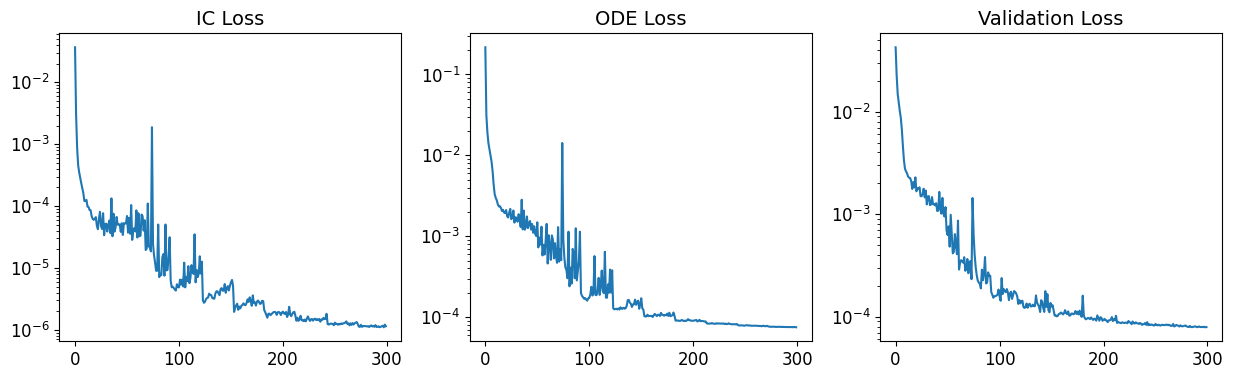

In [15]:
# History
%matplotlib inline
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].plot(range(n_epochs), loss_tracker.loss_history['IC_loss'])
ax[1].plot(range(n_epochs), loss_tracker.loss_history['ODE_loss'])
ax[2].plot(range(n_epochs), val_loss_hist)
ax[0].set_title('IC Loss', fontsize=14)
ax[1].set_title('ODE Loss', fontsize=14)
ax[2].set_title('Validation Loss', fontsize=14)
for axs in ax:
    axs.set_yscale('log')
    axs.tick_params(axis='both', which='major', labelsize=12)

plt.savefig('loss.png', bbox_inches='tight', pad_inches=0, transparent=True)

#### Inspect accuracy on test set

In [16]:
# Create new model instance
PI_DeepONet = create_model(mean, var)

# Reload the saved model
PI_DeepONet.load_weights('NN_model.h5')

In [18]:
# Make prediction
pred_test = PI_DeepONet.predict({"forcing": X_test[:, 1:-1], "time": X_test[:, :1]}, batch_size=12800)

# Overall accuarcy
print(f"RMSE: {mean_squared_error(y_test.flatten(), pred_test.flatten()):.4e}") #squared=False

1/1 [==============================] - 0s 134ms/step
RMSE: 4.7448e-06


#### Convergence display

In [19]:
from matplotlib.animation import FuncAnimation
%matplotlib notebook

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 4))

# Define the initialization function
def init():
    # Set up the plot
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.15, 0.01)
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('s(t)', fontsize=14)
    ax.set_title(f"Epochs: {0}")
    ax.tick_params(axis='both', which='major', labelsize=12)

    return ax,

# Define the update function
def update(epoch):
    # Clear the previous frame
    ax.cla()

    # Plot the loss convergence
    pred, = ax.plot(np.linspace(0, 1, 100), pred_profiles[epoch].flatten(), label="Prediction")
    truth, = ax.plot(np.linspace(0, 1, 100), y_test[25*100:(25+1)*100, :], label="Ground Truth")
    ax.legend(prop={'size': 12})

    # Set the axes limits (if necessary)
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.15, 0.01)
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('s(t)', fontsize=14)
    ax.set_title(f"Epochs: {epoch}")
    ax.tick_params(axis='both', which='major', labelsize=12)

    return line,


# Create the animation
n_epochs = len(loss_tracker.loss_history['IC_loss'])  # Replace with the total number of epochs
frames = range(0, n_epochs, 2)
animation = FuncAnimation(fig, update, frames=frames, init_func=init, blit=True, interval=50)

# Display the animation
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

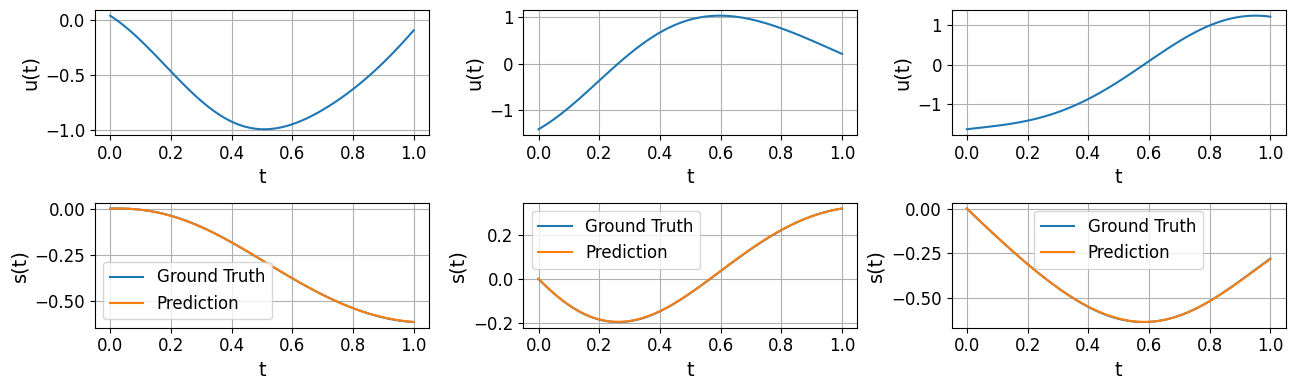

AttributeError: 'NoneType' object has no attribute 'remove_callback'

In [20]:
# Spot check
%matplotlib inline
fig, axs = plt.subplots(2, 3, figsize=(13, 4))
sample_id = np.random.choice(np.arange(0, 100), size=3, replace=False)
for i in range(3):
    ax = axs[0, i]
    ax.plot(np.linspace(0, 1, 100), X_test[sample_id[i]*100, 1:-1])
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('u(t)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True)


    ax = axs[1, i]
    ax.plot(np.linspace(0, 1, 100), y_test[sample_id[i]*100:(sample_id[i]+1)*100, :], label="Ground Truth")
    ax.plot(np.linspace(0, 1, 100), pred_test[sample_id[i]*100:(sample_id[i]+1)*100, :], label="Prediction")
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('s(t)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True)
    ax.legend(prop={'size': 12})

plt.tight_layout()
plt.savefig('testing.png', bbox_inches='tight', transparent=True)

#### Out-of-distribution prediction

In [21]:
# Create test dataset
N_test = 100
length_scale_test = 0.2
X, y = generate_dataset(N_test, length_scale_test, ODE_solve=True)

100%|██████████| 100/100 [00:00<00:00, 158.38it/s]


In [23]:
# Make prediction
pred = PI_DeepONet.predict({"forcing": X[:, 1:-1], "time": X[:, :1]}, batch_size=12800)

# Overall accuarcy
print(f"RMSE: {mean_squared_error(y.flatten(), pred.flatten()):.4e}") #, squared=False

1/1 [==============================] - 0s 46ms/step
RMSE: 3.2718e-03


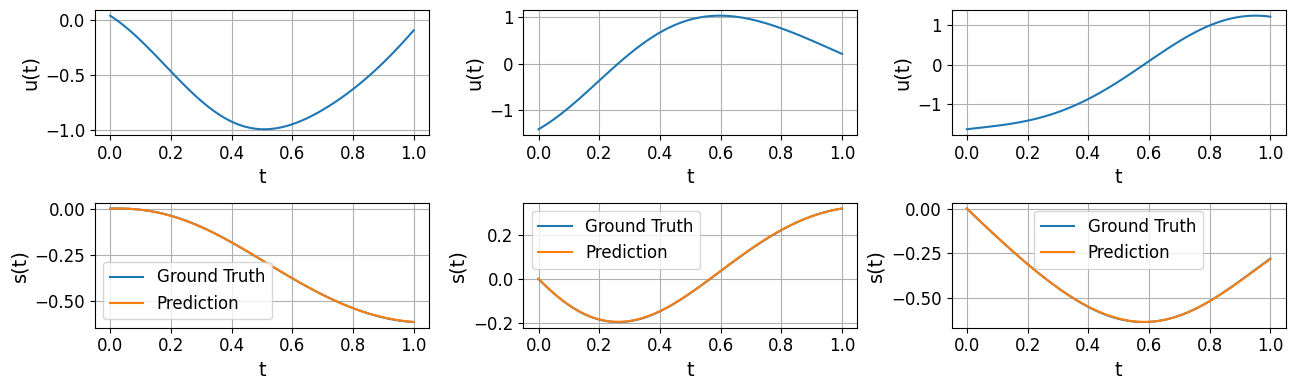

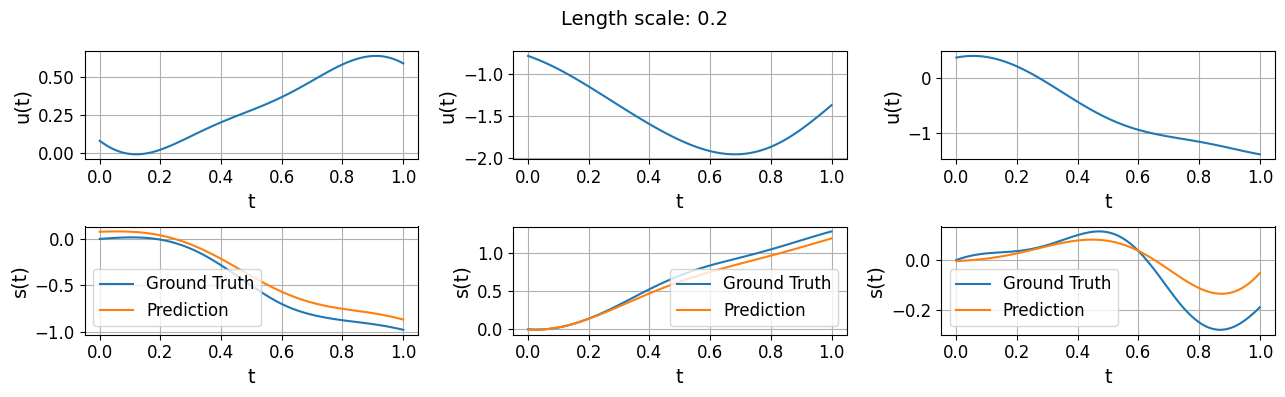

In [24]:
# Spot check
%matplotlib inline
fig, axs = plt.subplots(2, 3, figsize=(13, 4))
sample_id = np.random.choice(np.arange(0, 100), size=3, replace=False)
for i in range(3):
    ax = axs[0, i]
    ax.plot(np.linspace(0, 1, 100), X_test[sample_id[i]*100, 1:-1])
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('u(t)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True)


    ax = axs[1, i]
    ax.plot(np.linspace(0, 1, 100), y[sample_id[i]*100:(sample_id[i]+1)*100, :], label="Ground Truth")
    ax.plot(np.linspace(0, 1, 100), pred[sample_id[i]*100:(sample_id[i]+1)*100, :], label="Prediction")
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('s(t)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True)
    ax.legend(prop={'size': 12})

fig.suptitle(f'Length scale: {length_scale_test}', fontsize=14)
plt.tight_layout()
plt.savefig('testing_OOD.png', bbox_inches='tight', transparent=True)

#### Barplot for generalization capability

In [26]:
length_scale_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
RMSE = []
for length_scale in length_scale_list:
    # Create test dataset
    N_test = 100
    X, y = generate_dataset(N_test, length_scale, ODE_solve=True)

    # Make prediction
    pred = PI_DeepONet.predict({"forcing": X[:, 1:-1], "time": X[:, :1]}, batch_size=12800)

    # Overall accuarcy
    RMSE.append(mean_squared_error(y.flatten(), pred.flatten())) #, squared=False

100%|██████████| 100/100 [00:00<00:00, 367.81it/s]


1/1 [==============================] - 0s 45ms/step


100%|██████████| 100/100 [00:00<00:00, 480.56it/s]


1/1 [==============================] - 0s 50ms/step


100%|██████████| 100/100 [00:00<00:00, 473.65it/s]


1/1 [==============================] - 0s 45ms/step


100%|██████████| 100/100 [00:00<00:00, 546.43it/s]


1/1 [==============================] - 0s 46ms/step


100%|██████████| 100/100 [00:00<00:00, 458.20it/s]


1/1 [==============================] - 0s 68ms/step


100%|██████████| 100/100 [00:00<00:00, 347.08it/s]


1/1 [==============================] - 0s 76ms/step


100%|██████████| 100/100 [00:00<00:00, 595.66it/s]


1/1 [==============================] - 0s 40ms/step


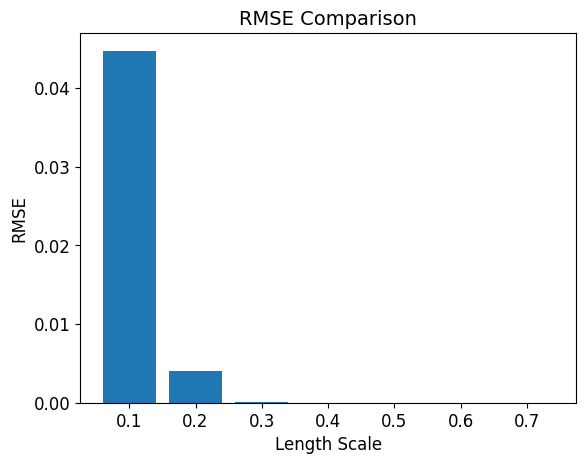

In [27]:
# Generate bar plot
plt.bar(range(len(RMSE)), RMSE)

# Set x-axis tick labels
plt.xticks(range(len(RMSE)), length_scale_list)

# Set x and y axis labels
plt.xlabel('Length Scale', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)

# Set a title for the plot
plt.title('RMSE Comparison', fontsize=14)

# Save the plot
plt.savefig('testing_OOD_bar.png', bbox_inches='tight', transparent=True)